# Fourier Transform and Quantum Computing
## Fourier Series
Functions can be described as a summation of sinusoidal functions. More specifically, different frequencies of sines and cosines all with different amplitudes can estimate a given function over a given period, T. 
$$
s_n(x) = A_0 + \sum_{n=1}^N(A_n cos(2\pi\frac{n}{T}x) + B_n sin(2\pi\frac{n}{T}x))
$$
Cosine and sine in their polar form are $\frac{e^{i\theta}+e^{-i\theta}}{2}$ and $\frac{e^{i\theta}-e^{-i\theta}}{2i}$ respectively. Replacing the summation above with these new definition, we get a new summation where we will be using the rest of the derivation.
$$
s_n(x) = \sum_{n=-N}^NC_ne^{i2\pi\frac{n}{T}x}
$$
## Sampling
Most audio is captured at around 44.1kHz or 48kHz. This means every second, we measure the amplitude of audio 44100 times. The wav file contains 44100 points of data for one second, which we will analyze in this notebook. The csv file contains the time the amplitude it was recorded and the amplitude measured in the format: "time", "amplitude".
```code
0.00000,-0.46933
0.00002,-0.46011
0.00005,-0.44931
0.00007,-0.41455
0.00009,-0.38632
0.00011,-0.34164
...
0.99995,0.12454
0.99998,0.13571
```
To find the frequencies that make up the audio, we'll use the *discrete Fourier Transform* where $a_0=-0.46933$, $a_1=-0.46011$, ... and so on. Since there are 44100 points of data, we'll set $N=44100$. Each frequency, $\phi$ will be defined as:
$$
\phi_{k} = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}a_je^{2\pi ijk/N}
$$
For example:
$$
\phi_{0} = \frac{1}{44100}(-0.46933e^{2\pi i(0)(0)/44100}-0.46011e^{2\pi i(1)(0)/44100}+...+0.13571e^(44099)(0)(44100))=-0.0973861\\
\phi_{1} = \frac{1}{44100}(-0.46933e^{2\pi i(0)(1)/44100}-0.46011e^{2\pi i(1)(1)/44100}+...+0.13571e^(44099)(1)(44100))=−0.118737+0.136405i\\
. \\
. \\
. \\
\phi_{44099} = \frac{1}{44100}(-0.46933e^{2\pi i(0)(44099)/44100}-0.46011e^{2\pi i(1)(44099)/44100}+...+0.13571e^(44099)(44099)(44100))=−0.118737−0.136405i
$$
One thing to notice is that $\phi_{1}=\phi_{44099}^*$. This remain true such that $\phi_{k}=\phi_{N-k}^*$ for k = $1, 2, ... , N/2 - 1$ so $\phi_{0}$ and $\phi{N/2}$ are unique. Taking the norm and plotting the frequencies against amplitude results in a frequency spectrum. 
## Classical Computing
Calculating one $\phi_{k}$ requires summing N terms with N different $\phi_{k}$, this computation becomes $O(N^2)$. Although this is polynomial time, which is better than some other problems out there such as Traveling Salseman, when analyzing large amounts of data this algorithm can become very slow. Another way to approach this problem is to think of it as a matrix-vector multiplication where $\omega = e^{2\pi i/N}$. The fourier transform becomes:
$$
\phi_{k} = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}a_j\omega^{jk}
$$
For example:
$$
\phi_{0} = \frac{1}{\sqrt{N}}(a_0 + a_1 + a_2 + ... + a_{N-1}),\\
\phi_{1} = \frac{1}{\sqrt{N}}(a_0 + a_1\omega +  a_2\omega^2 + ... + a_{N-1}\omega^{N-1}),\\
\phi_{2} = \frac{1}{\sqrt{N}}(a_0 + a_1\omega^2 +  a_2\omega^4 + ... + a_{N-1}\omega^{2(N-1)}),\\
. \\
. \\
. \\
\phi{k} = \frac{1}{\sqrt{N}}(a_0 + a_1\omega^{N-1} +  a_2\omega^{2(N-1)} + ... + a_{N-1}\omega^{(N-1)^2})
$$
Writing the equations as a matrix results in:
$$
\begin{pmatrix}
    \phi_{0}\\
    \phi_{1}\\
    \phi_{2}\\
    \vdots\\
    \phi_{N-1}\\
\end{pmatrix} = 
\begin{pmatrix}
    1 & 1 & 1 & \cdot & 1 \\
    1 & \omega & \omega^2 & \cdots & \omega^{N-1} \\
    1 & \omega^2 & \omega^4 & \cdots & \omega^{2(N-1)} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & \omega^{N-1} & \omega^{2(N-1)} & \cdots & \omega{(N-1)^2}
\end{pmatrix}
\begin{pmatrix}
    a_0 \\
    a_1 \\
    a_2 \\
    \vdots\\
    a_{N-1}
\end{pmatrix}
$$
Although this is useful conceptually, the amount of operations are still the same, $O(N^2)$. There are some algorithms out there that have runtimes of $O(N\log N)$ but biggest thing to note is that the $N$ x $N$ matrix is unitary.

## Quantum Computing
$$
\ket{\phi} =
\begin{pmatrix}
    \phi_0\\
    \phi_1\\
    \phi_2\\
    \vdots\\
    \phi_{N-1}
\end{pmatrix} = 
\phi_0\ket{0}+...+\phi_{N-1}\ket{N-1}
$$

Install these packages if you haven't already.

In [ ]:
%pip install qiskit[visualization]==1.0.2
%pip install qiskit-ibm-runtime
%pip install qiskit-aer
%pip install graphviz
%pip install qiskit-serverless -U
%pip install qiskit-transpiler-service -U

Make sure to create a textfile of your token. Alternatively, replace the variable *token* with your token

In [11]:
token = open("token.txt")
%set_env QXToken=token

env: QXToken=token


The imports needed to run the rest of the code

In [14]:
from qiskit import QuantumCircuit, transpiler
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT
import matplotlib.pyplot as plt
import csv, math, librosa, numpy

This is sample code to show how a quantum circuit is used to calculate fourier transform

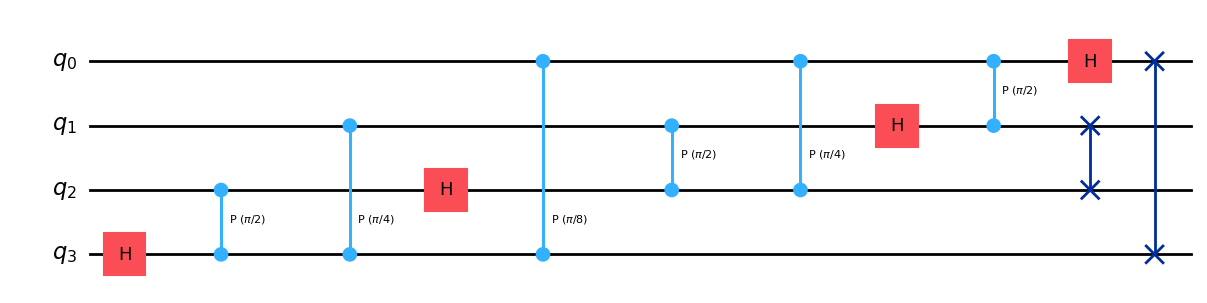

In [18]:
n=4
# Create a quantum circuit.
qc = QuantumCircuit(n)
# Iterate through each target qubit from (n-1) to 0.
for target in range(n-1,-1,-1):
# Apply the Hadamard gate.
    qc.h(target)
# Iterate through the control qubits from (target-1) to 0.
    for control in range(target-1,-1,-1):
    # Calculate "r," the rotation by 2*pi/2**r.
        r = target - control + 1
# Apply the controlled phase/rotation.
        qc.cp(2*math.pi/2**r, control, target)
# Swap qubits.
for qubit in range(n//2):
    qc.swap(qubit, n - qubit - 1)
# Draw the circuit.
qc.draw("mpl")


In [9]:

def normalize(data):
    '''
    Given an array of data, normalize the data such that the sum of the squared elements = 1
    Parameters:
        data - The array of values to be normalized
    Return:
        returns a normalized list of values
    '''
    sum_of_squares = sum(x**2 for x in data)
    norm_factor = math.sqrt(sum_of_squares)
    return [x / norm_factor for x in data]

In [10]:
quantum_data = []

filename = "Fourier Transform\g major chord.csv"
with open(filename, mode='r') as file:
    csv_reader = csv.reader(file)
    for i, row in enumerate(csv_reader):
        if i >= 2**15:  # Only take the first 32,768 data points 
            break
        quantum_data.append(float(row[1]))
normalized_data = normalize(quantum_data)

In [142]:
# Step 3: Prepare Quantum Circuit
num_qubits = int(np.ceil(np.log2(len(data))))
qc = QuantumCircuit(num_qubits)

# Initialize the quantum state with the sound data
qc.initialize(normalized_data[:2**15], qc.qubits) 

In [143]:
for target in range(num_qubits-1,-1,-1):
# Apply the Hadamard gate.
    qc.h(target)
# Iterate through the control qubits from (target-1) to 0.
    for control in range(target-1,-1,-1):
    # Calculate "r," the rotation by 2*pi/2**r.
        r = target - control + 1
# Apply the controlled phase/rotation.
        qc.cp(2*np.pi/2**r, control, target)
# Swap qubits.
for qubit in range(num_qubits//2):
    qc.swap(qubit, num_qubits - qubit - 1)
# Draw the circuit.
qc.draw("mpl")

# Step 5: Measure and Extract Results
qc.measure_all()

# Execute the quantum circuit
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots=1024)
result = job.result()
counts = result.get_counts(compiled_circuit)

frequencies = np.array([counts.get(format(i, f'0{num_qubits}b'), 0) for i in range(len(data))])
frequencies = frequencies / np.sum(frequencies)


In [144]:
classical_data = []
with open(filename, mode='r') as file:
    csv_reader = csv.reader(file)
    for i, row in enumerate(csv_reader):
        if i >= 2**15:  # Only take the first 32,768 data points 
            break
        classical_data.append(float(row[1]))
classical_data = normalize(classical_data)

classical_dft = np.fft.fft(classical_data)
classical_magnitudes = np.abs(classical_dft)**2
classical_magnitudes /= np.sum(classical_magnitudes)  # Normalize

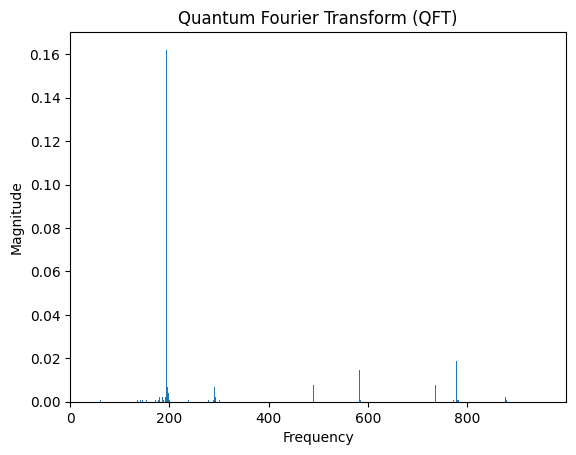

(0.0, 999.0)

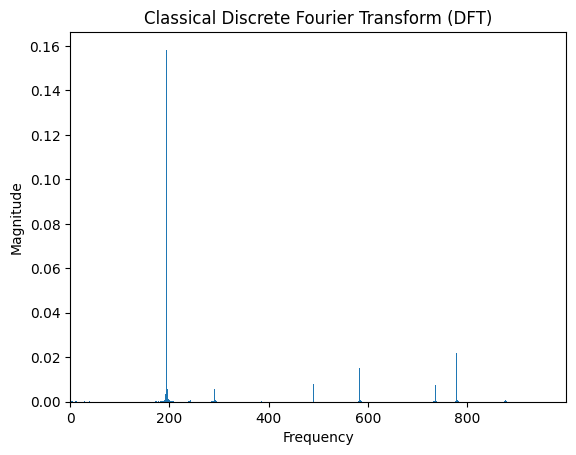

In [145]:
frequency_limit = 1000


# Plot the frequencies
plt.bar(range(len(frequencies)), frequencies)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Quantum Fourier Transform (QFT)')
plt.xlim(0, frequency_limit - 1)
plt.show()


plt.bar(range(len(classical_magnitudes)), classical_magnitudes)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Classical Discrete Fourier Transform (DFT)')
plt.xlim(0, frequency_limit - 1)
